## End-to-End Multi-Modal Transformer Implementation (Inline)

### Introduction: Extending the Transformer for Vision and Language

**Recap: The Text-Only Transformer**

In `transformer.ipynb`, we built and trained a Decoder-only Transformer model capable of generating text character by character. It learned patterns in text sequences using components like token embeddings, positional encoding, masked multi-head self-attention, and feed-forward networks. We saved the trained parameters (weights and configuration) in `saved_models/transformer_model.pt`.

**The Multi-Modal Challenge**

Our goal now is to extend this model to understand and reason about *both* visual information (images) and text prompts simultaneously. We want to build a system that can, for instance, look at an image and answer a question about it or describe it based on a textual prompt.

**Our Approach: Vision Feature Extraction + Fusion**

1.  **Load Pre-trained Text Model:** We will start by loading the weights and configuration from our previously trained character-level Transformer. This gives us a head start on text processing.
2.  **Vision Feature Extraction:** We need a way to convert an image into a numerical representation that the Transformer can understand. We will use a pre-trained Convolutional Neural Network (CNN), specifically ResNet-18 provided by `torchvision`, as a feature extractor. We will remove its final classification layer and use the output of its penultimate layer as a fixed-size feature vector representing the image content.
3.  **Feature Projection:** The image feature vector will likely have a different dimension than our Transformer's `d_model`. We will add a learnable linear layer to project the image features into the `d_model` space.
4.  **Modality Fusion (Simple Concatenation):** We will represent the image conceptually as one or more special "image tokens" at the beginning of the input sequence. We'll add a special `<IMG>` token to our vocabulary. The projected image features will be associated with this `<IMG>` token embedding. The input to the Transformer will then be a sequence starting with the image representation followed by the tokenized text prompt.
5.  **Training:** We will fine-tune the entire model (or parts of it) on a small dataset of (Image, Prompt, Response) triplets. The model learns to attend to both the image features and the prompt text to generate the correct response.
6.  **Inference/Generation:** Given a new image and prompt, we will extract image features, combine them with the tokenized prompt, and use the trained model to autoregressively generate the text response character by character, similar to the text-only generation process.

**Inline Implementation Style**

As requested, we will implement this entire process inline, step-by-step, with detailed explanations for each small code block, avoiding functions and classes.

### Step 0: Setup - Libraries, Loading, Data, Vision Model

**Goal:** Prepare the environment, load the pre-trained text model, define sample multi-modal data, and set up the vision feature extractor.

#### Step 0.1: Import Libraries

**Theory:** We need `torch` and its submodules (`nn`, `F`, `optim`). We also need `torchvision` for the pre-trained ResNet model and image transformations, `PIL` (Pillow) for loading images, `math` for calculations, and `os` for path handling.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import math
import os
import numpy as np # For creating dummy images

# For reproducibility (optional, but good practice)
torch.manual_seed(42) # Use a different seed for variation
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print("Libraries imported.")

# --- Device Configuration ---
# Theory: Set the device (GPU if available, else CPU) for tensor operations.
# This ensures that models and data are processed on the same hardware.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu118
Torchvision version: 0.21.0+cu118
Libraries imported.
Using device: cuda


#### Step 0.2: Load Pre-trained Text Model State

**Theory:** Load the saved state dictionary from `transformer_model.pt`. This dictionary contains the weights of the previously trained character-level Transformer, its configuration (hyperparameters like `d_model`, `n_layers`, etc.), and the character tokenizer mappings (`char_to_int`, `int_to_char`). We extract these components to rebuild and extend the model.

In [2]:
# --- Load Saved Text Model State ---
# Theory: Load the dictionary saved from the previous notebook.
# This contains model weights, configuration, and tokenizer info.
print("\nStep 0.2: Loading pre-trained text model state...")
model_load_path = 'saved_models/transformer_model.pt'
if not os.path.exists(model_load_path):
    raise FileNotFoundError(f"Error: Model file not found at {model_load_path}. Please ensure 'transformer2.ipynb' was run and saved the model.")

loaded_state_dict = torch.load(model_load_path, map_location=device)
print(f"Loaded state dictionary from '{model_load_path}'.")

# --- Extract Config and Tokenizer ---
# Theory: Retrieve the hyperparameters and tokenizer mappings saved within the state dict.
# These are essential for rebuilding the model structure and processing text.
config = loaded_state_dict['config']
loaded_vocab_size = config['vocab_size']
d_model = config['d_model']
n_heads = config['n_heads']
n_layers = config['n_layers']
d_ff = config['d_ff']
loaded_block_size = config['block_size'] # Max sequence length for text model
d_k = d_model // n_heads

char_to_int = loaded_state_dict['tokenizer']['char_to_int']
int_to_char = loaded_state_dict['tokenizer']['int_to_char']

print("Extracted model configuration and tokenizer:")
print(f"  Loaded vocab_size: {loaded_vocab_size}")
print(f"  d_model: {d_model}")
print(f"  n_layers: {n_layers}")
print(f"  n_heads: {n_heads}")
print(f"  d_ff: {d_ff}")
print(f"  Loaded block_size: {loaded_block_size}")


Step 0.2: Loading pre-trained text model state...
Loaded state dictionary from 'saved_models/transformer_model.pt'.
Extracted model configuration and tokenizer:
  Loaded vocab_size: 36
  d_model: 64
  n_layers: 3
  n_heads: 4
  d_ff: 256
  Loaded block_size: 32


#### Step 0.3: Define Special Tokens and Update Vocabulary

**Theory:** For our multi-modal setup, we need special tokens:
*   `<IMG>`: A placeholder token representing the image input in the sequence.
*   `<PAD>`: A token used for padding sequences to a fixed length (`block_size`). Padding is necessary for batch processing.
*   `<EOS>`: (Optional but good practice) An End-of-Sentence token to signal the model when to stop generation.
We add these to our existing character vocabulary and update the `vocab_size` and mappings.

In [3]:
print("\nStep 0.3: Defining special tokens and updating vocabulary...")

# --- Define Special Tokens ---
img_token = "<IMG>"
pad_token = "<PAD>"
eos_token = "<EOS>" # End-of-Sentence/Sequence
special_tokens = [img_token, pad_token, eos_token]

# --- Add Special Tokens to Vocabulary ---
# Theory: Integrate the new special tokens into the existing character mappings.
# We assign new unique integer IDs to them. The vocab_size increases.
current_vocab_size = loaded_vocab_size
for token in special_tokens:
    if token not in char_to_int:
        char_to_int[token] = current_vocab_size
        int_to_char[current_vocab_size] = token
        current_vocab_size += 1

# Update vocab_size
vocab_size = current_vocab_size
pad_token_id = char_to_int[pad_token] # Store the ID for later use

print(f"Added special tokens: {special_tokens}")
print(f"Updated vocabulary size: {vocab_size}")
print(f"PAD token ID: {pad_token_id}")
# print(f"Updated char_to_int mapping includes: { {k: char_to_int[k] for k in special_tokens} }")


Step 0.3: Defining special tokens and updating vocabulary...
Added special tokens: ['<IMG>', '<PAD>', '<EOS>']
Updated vocabulary size: 39
PAD token ID: 37


#### Step 0.4: Define Sample Multi-Modal Data

**Theory:** Create a small, synthetic dataset of (image, prompt, response) triplets. For simplicity, we'll generate dummy images (e.g., solid colors) using PIL/Numpy and pair them with descriptive prompts and answers. In a real scenario, this would be a large dataset like COCO Captions, VQAv2, etc.

In [4]:
print("\nStep 0.4: Defining sample multi-modal data...")

# --- Create Dummy Image Files ---
# Theory: Generate simple images (e.g., solid colors) and save them.
# This avoids needing external image datasets for this inline example.
sample_data_dir = "sample_multimodal_data"
os.makedirs(sample_data_dir, exist_ok=True)

image_paths = {
    "red": os.path.join(sample_data_dir, "red_square.png"),
    "blue": os.path.join(sample_data_dir, "blue_square.png"),
    "green": os.path.join(sample_data_dir, "green_circle.png") # Let's add a shape difference
}

# Create Red Square
img_red = Image.new('RGB', (64, 64), color = 'red')
img_red.save(image_paths["red"])
# Create Blue Square
img_blue = Image.new('RGB', (64, 64), color = 'blue')
img_blue.save(image_paths["blue"])
# Create Green Circle (approximate with PIL draw)
img_green = Image.new('RGB', (64, 64), color = 'white')
from PIL import ImageDraw
draw = ImageDraw.Draw(img_green)
draw.ellipse((4, 4, 60, 60), fill='green', outline='green')
img_green.save(image_paths["green"])

print(f"Created dummy images in '{sample_data_dir}'.")

# --- Define Data Triplets ---
# Theory: Create pairs of (image_path, text_prompt, text_response).
# The prompts ask about the image, and responses provide the answer.
# Added <EOS> token to the end of responses.
sample_training_data = [
    {"image_path": image_paths["red"], "prompt": "What color is the shape?", "response": "red." + eos_token},
    {"image_path": image_paths["blue"], "prompt": "Describe the image.", "response": "a blue square." + eos_token},
    {"image_path": image_paths["green"], "prompt": "What shape is shown?", "response": "a green circle." + eos_token},
    {"image_path": image_paths["red"], "prompt": "Is it a circle?", "response": "no, it is a square." + eos_token},
    {"image_path": image_paths["blue"], "prompt": "What is the main color?", "response": "blue." + eos_token},
    {"image_path": image_paths["green"], "prompt": "Describe this.", "response": "a circle, it is green." + eos_token}
]

num_samples = len(sample_training_data)
print(f"Defined {num_samples} sample multi-modal data points.")
# print(f"Sample 0: {sample_training_data[0]}")


Step 0.4: Defining sample multi-modal data...
Created dummy images in 'sample_multimodal_data'.
Defined 6 sample multi-modal data points.


#### Step 0.5: Load Pre-trained Vision Model (Feature Extractor)

**Theory:** Load a pre-trained ResNet-18 model from `torchvision`. We remove its final fully connected layer (`fc`), which was originally used for ImageNet classification. The output of the layer *before* `fc` (the adaptive average pooling layer) will serve as our image feature vector. We set the model to evaluation mode (`eval()`) and disable gradients as we will *not* be fine-tuning the vision backbone in this simple example (only the projection layer and the text transformer).

In [5]:
print("\nStep 0.5: Loading pre-trained vision model (ResNet-18)...")

# --- Load Pre-trained ResNet-18 ---
# Using weights=ResNet18_Weights.DEFAULT for the latest recommended weights
vision_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# --- Remove Final Classification Layer ---
# Theory: We want image features, not class predictions. Access the layer before 'fc'.
# In ResNet, the features are output by the adaptive average pooling layer just before 'fc'.
# We can replace 'fc' with an identity layer or simply use a hook/modify the forward pass.
# Easiest inline: Replace fc with an identity mapping.
vision_feature_dim = vision_model.fc.in_features # Get the input dimension of the original fc layer
vision_model.fc = nn.Identity() # Replace the classifier

# --- Set to Evaluation Mode and Move to Device ---
vision_model = vision_model.to(device)
vision_model.eval() # Set to evaluation mode (disables dropout, batchnorm updates)

print(f"Loaded ResNet-18 feature extractor.")
print(f"  Output feature dimension: {vision_feature_dim}") # Should be 512 for ResNet-18
print(f"  Vision model set to evaluation mode on device: {device}")


Step 0.5: Loading pre-trained vision model (ResNet-18)...


Loaded ResNet-18 feature extractor.
  Output feature dimension: 512
  Vision model set to evaluation mode on device: cuda


#### Step 0.6: Define Image Transformations

**Theory:** Images need to be preprocessed before being fed into the ResNet model. This typically involves resizing them to a standard size (e.g., 224x224 for ResNet), converting them to PyTorch tensors, and normalizing their pixel values using the mean and standard deviation specific to the dataset the model was pre-trained on (ImageNet in this case). `torchvision.transforms` provides these utilities.

In [6]:
print("\nStep 0.6: Defining image transformations...")

# --- Define Standard ImageNet Transforms ---
# Theory: Use the standard transformations recommended for models pre-trained on ImageNet.
# Resize, Center Crop (optional but common), ToTensor, Normalize.
image_transforms = transforms.Compose([
    transforms.Resize(256),            # Resize smaller edge to 256
    transforms.CenterCrop(224),        # Crop center 224x224 square
    transforms.ToTensor(),             # Convert PIL Image to FloatTensor (0-1 range)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std dev
])

print("Defined image preprocessing pipeline (Resize, Crop, ToTensor, Normalize).")


Step 0.6: Defining image transformations...
Defined image preprocessing pipeline (Resize, Crop, ToTensor, Normalize).


#### Step 0.7: Define New Hyperparameters

**Theory:** Define any new hyperparameters specific to the multi-modal setup. We'll set a `block_size` for the combined sequence length (image features + text). It might need to be larger than the original `loaded_block_size` to accommodate both modalities. We also define the number of image "tokens" we'll use. For simplicity, we'll use one `<IMG>` token representing the global image feature.

In [7]:
print("\nStep 0.7: Defining new/updated hyperparameters...")

# --- Multi-Modal Sequence Length ---
# Theory: Define the maximum sequence length for the combined image + text input.
# Needs to accommodate image tokens + prompt + response (during training).
# Let's try a slightly larger size than the original text block size.
block_size = 64 # Max length for combined sequence (e.g., 1 IMG + prompt + response)
print(f"  Set combined block_size: {block_size}")

# --- Number of Image Tokens ---
# Theory: How many token positions will represent the image? We'll use 1 for simplicity.
num_img_tokens = 1
print(f"  Using {num_img_tokens} <IMG> token(s) to represent image features.")

# --- Training Parameters ---
# Re-state or adjust training parameters if needed
learning_rate = 3e-4 # Keep the same AdamW learning rate
batch_size = 4 # Reduce batch size due to potentially larger memory footprint
epochs = 2000  # Increase epochs further for multi-modal learning
eval_interval = 500

print(f"  Updated Training Params: LR={learning_rate}, BatchSize={batch_size}, Epochs={epochs}")

# Ensure block_size is sufficient
min_req_block_size = num_img_tokens + max(len(d["prompt"]) + len(d["response"]) for d in sample_training_data) + 1 # +1 for safety/EOS
print(f"  Max sequence length in sample data (approx): {min_req_block_size}")
if block_size < min_req_block_size:
     print(f"Warning: block_size ({block_size}) might be too small for the longest sample sequence ({min_req_block_size}). Consider increasing it.")

# Recreate the causal mask for the new block_size
# Shape: (1, 1, block_size, block_size)
causal_mask = torch.tril(torch.ones(block_size, block_size, device=device)).view(1, 1, block_size, block_size)
print(f"  Recreated causal mask for new block_size={block_size}")


Step 0.7: Defining new/updated hyperparameters...
  Set combined block_size: 64
  Using 1 <IMG> token(s) to represent image features.
  Updated Training Params: LR=0.0003, BatchSize=4, Epochs=2000
  Max sequence length in sample data (approx): 43
  Recreated causal mask for new block_size=64


### Step 1: Data Preparation for Multi-Modal Training

**Goal:** Process the sample data: extract image features, tokenize text, combine them into sequences suitable for the Transformer, and prepare batches.

#### Step 1.1: Extract Image Features for Sample Data

**Theory:** Iterate through our `sample_training_data`. For each unique image path, load the image, apply the defined transformations, and pass it through the frozen `vision_model` to get the feature vector. Store these features in a dictionary mapping image paths to feature tensors. This avoids redundant computation during training batch creation.

In [8]:
print("\nStep 1.1: Extracting image features for sample data...")
extracted_image_features = {} # Dict to store {image_path: feature_tensor}

# --- Loop Through Unique Image Paths ---
unique_image_paths = set(d["image_path"] for d in sample_training_data)
print(f"Found {len(unique_image_paths)} unique images to process.")

for img_path in unique_image_paths:
    # --- Load Image ---
    # Theory: Open the image file using Pillow.
    try:
        img = Image.open(img_path).convert('RGB') # Ensure image is RGB
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}. Skipping.")
        continue

    # --- Apply Transformations ---
    # Theory: Apply the predefined preprocessing pipeline (resize, crop, tensor, normalize).
    # Unsqueeze(0) adds a batch dimension (B=1) as expected by the vision model.
    img_tensor = image_transforms(img).unsqueeze(0).to(device) # Shape: (1, 3, 224, 224)

    # --- Extract Features ---
    # Theory: Pass the preprocessed image tensor through the vision model.
    # Use torch.no_grad() as we are not training the vision model here.
    with torch.no_grad():
        feature_vector = vision_model(img_tensor) # Shape: (1, vision_feature_dim)

    # --- Store Features ---
    extracted_image_features[img_path] = feature_vector.squeeze(0) # Remove batch dim, store (feature_dim,)
    print(f"  Extracted features for '{os.path.basename(img_path)}', shape: {extracted_image_features[img_path].shape}")

print("Finished extracting image features for all unique sample images.")


Step 1.1: Extracting image features for sample data...
Found 3 unique images to process.
  Extracted features for 'green_circle.png', shape: torch.Size([512])
  Extracted features for 'blue_square.png', shape: torch.Size([512])
  Extracted features for 'red_square.png', shape: torch.Size([512])
Finished extracting image features for all unique sample images.


#### Step 1.2: Tokenize Prompts and Responses

**Theory:** Convert the text prompts and responses from our sample data into sequences of integer IDs using the updated `char_to_int` mapping (which now includes `<IMG>`, `<PAD>`, `<EOS>`).

In [9]:
print("\nStep 1.2: Tokenizing prompts and responses...")

# First, extend vocabulary with any new characters
current_vocab_size = vocab_size  # Start from current vocabulary size
all_chars = set()

# Collect all unique characters from prompts and responses
for sample in sample_training_data:
    all_chars.update(sample["prompt"])
    # Remove EOS token from response before collecting chars
    response_text = sample["response"]
    if response_text.endswith(eos_token):
        response_text = response_text[:-len(eos_token)]
    all_chars.update(response_text)

# Add any new characters to vocabulary
new_chars_added = 0
for char in all_chars:
    if char not in char_to_int:
        char_to_int[char] = current_vocab_size
        int_to_char[current_vocab_size] = char
        current_vocab_size += 1
        new_chars_added += 1

vocab_size = current_vocab_size  # Update vocab size
print(f"Added {new_chars_added} new characters to vocabulary. New vocab_size: {vocab_size}")

# Now tokenize with the extended vocabulary
tokenized_samples = []
for sample in sample_training_data:
    # --- Tokenize Prompt ---
    prompt_ids = [char_to_int[ch] for ch in sample["prompt"]]

    # --- Tokenize Response ---
    response_text = sample["response"]
    if response_text.endswith(eos_token):
        response_text_without_eos = response_text[:-len(eos_token)]
        response_ids = [char_to_int[ch] for ch in response_text_without_eos] + [char_to_int[eos_token]]
    else:
        response_ids = [char_to_int[ch] for ch in response_text]

    tokenized_samples.append({
        "image_path": sample["image_path"],
        "prompt_ids": prompt_ids,
        "response_ids": response_ids
    })

print(f"Tokenized text for all {len(tokenized_samples)} samples.")


Step 1.2: Tokenizing prompts and responses...
Added 3 new characters to vocabulary. New vocab_size: 42
Tokenized text for all 6 samples.


#### Step 1.3: Create Padded Input/Target Sequences and Masks

**Theory:** Combine the image representation, tokenized prompt, and tokenized response into a single input sequence for the Transformer. Create the corresponding target sequence (shifted response) and an attention mask.
1.  **Input Sequence (`x`):** `[<IMG>_id] * num_img_tokens + prompt_ids + response_ids` (excluding the last token of response as it won't be predicted). Pad this sequence with `pad_token_id` up to `block_size`.
2.  **Target Sequence (`y`):** The target is to predict the *next* token. So, the target sequence corresponds to `prompt_ids + response_ids`, shifted one position. We'll set targets for the `<IMG>` and `prompt` parts to be ignored during loss calculation (using `ignore_index` which is often -100, but CrossEntropyLoss handles it via `ignore_index=pad_token_id` if we structure it carefully, or we manually mask the loss later). Pad with `pad_token_id`.
3.  **Attention Mask:** A mask indicating which positions the Transformer should attend to. It should prevent attention to `<PAD>` tokens. It combines the causal mask (for self-attention) and the padding mask. For simplicity here, we'll primarily create a padding mask and rely on the pre-computed `causal_mask` during the attention calculation. The padding mask is `1` for real tokens and `0` for pad tokens.

In [10]:
print("\nStep 1.3: Creating padded input/target sequences and masks...")

prepared_sequences = []
ignore_index = -100 # Common ignore index for CrossEntropyLoss

for sample in tokenized_samples:
    # --- Construct Input Sequence IDs ---
    img_ids = [char_to_int[img_token]] * num_img_tokens
    input_ids_no_pad = img_ids + sample["prompt_ids"] + sample["response_ids"][:-1] # Input predicts response

    # --- Construct Target Sequence IDs ---
    # Targets are shifted input: predict next token.
    # We only care about predicting the response tokens.
    # Set targets for image and prompt tokens to 'ignore_index'.
    target_ids_no_pad = ([ignore_index] * len(img_ids)) + \
                         ([ignore_index] * len(sample["prompt_ids"])) + \
                         sample["response_ids"]

    # --- Padding ---
    current_len = len(input_ids_no_pad)
    pad_len = block_size - current_len

    if pad_len < 0:
        print(f"Warning: Sample sequence length ({current_len}) exceeds block_size ({block_size}). Truncating.")
        input_ids = input_ids_no_pad[:block_size]
        target_ids = target_ids_no_pad[:block_size]
        pad_len = 0 # No padding needed after truncation
        current_len = block_size
    else:
        input_ids = input_ids_no_pad + ([pad_token_id] * pad_len)
        target_ids = target_ids_no_pad + ([ignore_index] * pad_len) # Pad targets with ignore_index

    # --- Create Attention Mask (Padding Mask) ---
    # 1 for real tokens, 0 for padding tokens.
    attention_mask = ([1] * current_len) + ([0] * pad_len)

    # --- Store ---
    prepared_sequences.append({
        "image_path": sample["image_path"],
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "target_ids": torch.tensor(target_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long) # Or float for some implementations
    })

    # print(f"  Prepared Sample (Input IDs): {prepared_sequences[-1]['input_ids'].tolist()}")
    # print(f"  Prepared Sample (Target IDs): {prepared_sequences[-1]['target_ids'].tolist()}")
    # print(f"  Prepared Sample (Attn Mask): {prepared_sequences[-1]['attention_mask'].tolist()}")


# --- Stack into Tensors ---
# Theory: Group the processed sequences into tensors for easier batching.
all_input_ids = torch.stack([s['input_ids'] for s in prepared_sequences])
all_target_ids = torch.stack([s['target_ids'] for s in prepared_sequences])
all_attention_masks = torch.stack([s['attention_mask'] for s in prepared_sequences])
# Keep image paths associated for retrieving features during batching
all_image_paths = [s['image_path'] for s in prepared_sequences]

num_sequences_available = all_input_ids.shape[0]
print(f"Created {num_sequences_available} padded sequences with targets and masks.")
print(f"  Input IDs shape: {all_input_ids.shape}") # (num_samples, block_size)
print(f"  Target IDs shape: {all_target_ids.shape}") # (num_samples, block_size)
print(f"  Attention Mask shape: {all_attention_masks.shape}") # (num_samples, block_size)


Step 1.3: Creating padded input/target sequences and masks...
Created 6 padded sequences with targets and masks.
  Input IDs shape: torch.Size([6, 64])
  Target IDs shape: torch.Size([6, 65])
  Attention Mask shape: torch.Size([6, 64])


In [11]:
# Define maximum sequence length for consistency
max_seq_len = 64  # This should match what your model expects

# Ensure all sequences are properly sized
for i in range(len(tokenized_samples)):
    # Ensure response_ids don't exceed max length
    if len(tokenized_samples[i]["response_ids"]) > max_seq_len:
        tokenized_samples[i]["response_ids"] = tokenized_samples[i]["response_ids"][:max_seq_len]
    
    # Also check prompt_ids if needed
    if len(tokenized_samples[i]["prompt_ids"]) > max_seq_len:
        tokenized_samples[i]["prompt_ids"] = tokenized_samples[i]["prompt_ids"][:max_seq_len]

print(f"All sequences adjusted to maximum length of {max_seq_len}")

All sequences adjusted to maximum length of 64


#### Step 1.4: Batching Strategy (Random Sampling)

**Theory:** Similar to the text-only model, we'll use simple random sampling. In each training step, we randomly select `batch_size` indices and retrieve the corresponding input IDs, target IDs, attention masks, and image features (using the associated image path).

In [12]:
print("\nStep 1.4: Preparing for batching...")

# Check if batch size is feasible
if num_sequences_available < batch_size:
    print(f"Warning: Number of sequences ({num_sequences_available}) is less than batch size ({batch_size}). Adjusting batch size.")
    batch_size = num_sequences_available

print(f"Data ready for training. Will sample batches of size {batch_size} randomly.")
# In the training loop, we will use random indices to get:
# xb_ids = all_input_ids[indices]
# yb_ids = all_target_ids[indices]
# batch_masks = all_attention_masks[indices]
# batch_img_paths = [all_image_paths[i] for i in indices.tolist()]
# batch_img_features = torch.stack([extracted_image_features[p] for p in batch_img_paths])


Step 1.4: Preparing for batching...
Data ready for training. Will sample batches of size 4 randomly.


### Step 2: Model Adaptation and Initialization

**Goal:** Re-initialize the parts of the model that changed (embedding table, output layer due to vocab size) and initialize the new vision projection layer.

#### Step 2.1: Re-initialize Embedding and Output Layers

**Theory:** Since we added special tokens (`<IMG>`, `<PAD>`, `<EOS>`), the `vocab_size` has changed. The `token_embedding_table` and the `output_linear_layer` need to be resized to accommodate this. We load the weights from the saved state for the *original* vocabulary part and initialize the new rows (for the special tokens) randomly.

In [13]:
print("\nStep 2.1: Re-initializing Embedding and Output Layers for new vocab size...")

# --- Token Embedding Table ---
new_token_embedding_table = nn.Embedding(vocab_size, d_model).to(device)
# Load weights for the original vocabulary part
original_weights = loaded_state_dict['token_embedding_table']['weight'][:loaded_vocab_size, :]
with torch.no_grad():
    new_token_embedding_table.weight[:loaded_vocab_size, :] = original_weights
    # New tokens (<IMG>, <PAD>, <EOS>) are randomly initialized by default, which is fine.
token_embedding_table = new_token_embedding_table # Replace the old variable
print(f"  Re-initialized Token Embedding Table, shape: {token_embedding_table.weight.shape}")

# --- Output Linear Layer ---
new_output_linear_layer = nn.Linear(d_model, vocab_size).to(device)
# Load weights and biases for the original vocabulary part
original_out_weight = loaded_state_dict['output_linear_layer']['weight'][:loaded_vocab_size, :]
original_out_bias = loaded_state_dict['output_linear_layer']['bias'][:loaded_vocab_size]
with torch.no_grad():
    new_output_linear_layer.weight[:loaded_vocab_size, :] = original_out_weight
    new_output_linear_layer.bias[:loaded_vocab_size] = original_out_bias
    # Weights/biases for new tokens are randomly initialized.
output_linear_layer = new_output_linear_layer # Replace the old variable
print(f"  Re-initialized Output Linear Layer, weight shape: {output_linear_layer.weight.shape}")


Step 2.1: Re-initializing Embedding and Output Layers for new vocab size...
  Re-initialized Token Embedding Table, shape: torch.Size([42, 64])
  Re-initialized Output Linear Layer, weight shape: torch.Size([42, 64])


#### Step 2.2: Initialize Vision Projection Layer

**Theory:** Create and initialize the new linear layer that projects the extracted image features (dimension `vision_feature_dim`) to the Transformer's hidden dimension (`d_model`). This layer is crucial for making the image information compatible with the text embeddings.

In [14]:
print("\nStep 2.2: Initializing Vision Projection Layer...")

vision_projection_layer = nn.Linear(vision_feature_dim, d_model).to(device)

print(f"  Initialized Vision Projection Layer: {vision_feature_dim} -> {d_model}. Device: {device}")


Step 2.2: Initializing Vision Projection Layer...
  Initialized Vision Projection Layer: 512 -> 64. Device: cuda


#### Step 2.3: Load Existing Transformer Block Layers

**Theory:** We need to reload the parameters for the core Transformer blocks (LayerNorms, QKV/Output Linears for MHA, FFN Linears) from the loaded state dictionary. We place them back into lists, just like in `transformer2.ipynb`.

In [15]:
print("\nStep 2.3: Loading parameters for existing Transformer Blocks...")

# Lists to store layers for each Transformer block
layer_norms_1 = []
layer_norms_2 = []
mha_qkv_linears = []
mha_output_linears = []
ffn_linear_1 = []
ffn_linear_2 = []

# Load components for each layer from the state dict
for i in range(n_layers):
    # LayerNorm 1
    ln1 = nn.LayerNorm(d_model).to(device)
    ln1.load_state_dict(loaded_state_dict['layer_norms_1'][i])
    layer_norms_1.append(ln1)

    # MHA QKV Linear
    qkv_linear = nn.Linear(d_model, 3 * d_model, bias=False).to(device)
    qkv_linear.load_state_dict(loaded_state_dict['mha_qkv_linears'][i])
    mha_qkv_linears.append(qkv_linear)

    # MHA Output Linear
    output_linear_mha = nn.Linear(d_model, d_model).to(device)
    output_linear_mha.load_state_dict(loaded_state_dict['mha_output_linears'][i])
    mha_output_linears.append(output_linear_mha) # Renamed to avoid conflict

    # LayerNorm 2
    ln2 = nn.LayerNorm(d_model).to(device)
    ln2.load_state_dict(loaded_state_dict['layer_norms_2'][i])
    layer_norms_2.append(ln2)

    # FFN Linear 1
    lin1 = nn.Linear(d_model, d_ff).to(device)
    lin1.load_state_dict(loaded_state_dict['ffn_linear_1'][i])
    ffn_linear_1.append(lin1)

    # FFN Linear 2
    lin2 = nn.Linear(d_ff, d_model).to(device)
    lin2.load_state_dict(loaded_state_dict['ffn_linear_2'][i])
    ffn_linear_2.append(lin2)

    print(f"  Loaded components for Layer {i+1}/{n_layers}.")

# Load Final LayerNorm
final_layer_norm = nn.LayerNorm(d_model).to(device)
final_layer_norm.load_state_dict(loaded_state_dict['final_layer_norm'])
print("  Loaded Final LayerNorm.")

# Load Positional Encoding (not a parameter, but needed)
positional_encoding = loaded_state_dict['positional_encoding'].to(device)
# Adjust positional encoding if block_size changed significantly
if positional_encoding.shape[1] != block_size:
     print(f"Warning: Loaded positional encoding size ({positional_encoding.shape[1]}) != new block_size ({block_size}). Recomputing.")
     # Recompute PE for the new block_size (copy code from Step 0.5 of transformer2.ipynb if needed)
     # Or simply slice/pad the existing one if change is small (less accurate)
     # For simplicity, we'll just recreate it using the code from transformer2
     new_pe = torch.zeros(block_size, d_model, device=device)
     position = torch.arange(0, block_size, dtype=torch.float, device=device).unsqueeze(1)
     div_term_indices = torch.arange(0, d_model, 2, dtype=torch.float, device=device)
     div_term = torch.exp(div_term_indices * (-math.log(10000.0) / d_model))
     new_pe[:, 0::2] = torch.sin(position * div_term)
     new_pe[:, 1::2] = torch.cos(position * div_term)
     positional_encoding = new_pe.unsqueeze(0) # Add batch dim
     print(f"  Recomputed Positional Encoding matrix, shape: {positional_encoding.shape}")


print("Finished loading existing model components.")


Step 2.3: Loading parameters for existing Transformer Blocks...
  Loaded components for Layer 1/3.
  Loaded components for Layer 2/3.
  Loaded components for Layer 3/3.
  Loaded Final LayerNorm.
  Recomputed Positional Encoding matrix, shape: torch.Size([1, 64, 64])
Finished loading existing model components.


#### Step 2.4: Define Optimizer and Loss Function

**Theory:** Gather *all* trainable parameters, including the newly initialized vision projection layer and the resized embedding/output layers, into a list. Define the AdamW optimizer to manage these parameters. Define the Cross-Entropy loss function, making sure to set `ignore_index=ignore_index` (which we set to -100 earlier) so that padding tokens and non-target tokens (like prompt tokens) do not contribute to the loss calculation.

In [16]:
print("\nStep 2.4: Defining Optimizer and Loss Function...")

# --- Gather All Trainable Parameters ---
# Theory: Collect parameters from all components that need gradient updates.
# We are fine-tuning the text parts and training the new vision projection.
all_trainable_parameters = list(token_embedding_table.parameters())
all_trainable_parameters.extend(list(vision_projection_layer.parameters())) # Add new layer
for i in range(n_layers):
    all_trainable_parameters.extend(list(layer_norms_1[i].parameters()))
    all_trainable_parameters.extend(list(mha_qkv_linears[i].parameters()))
    all_trainable_parameters.extend(list(mha_output_linears[i].parameters())) # Use correct name
    all_trainable_parameters.extend(list(layer_norms_2[i].parameters()))
    all_trainable_parameters.extend(list(ffn_linear_1[i].parameters()))
    all_trainable_parameters.extend(list(ffn_linear_2[i].parameters()))
all_trainable_parameters.extend(list(final_layer_norm.parameters()))
all_trainable_parameters.extend(list(output_linear_layer.parameters()))

# --- Define Optimizer ---
optimizer = optim.AdamW(all_trainable_parameters, lr=learning_rate)
print(f"  Optimizer defined: AdamW with lr={learning_rate}")
print(f"  Managing {len(all_trainable_parameters)} parameter groups/tensors.")

# --- Define Loss Function ---
# Theory: Use CrossEntropyLoss with ignore_index set to ignore padding AND prompt tokens.
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
print(f"  Loss function defined: CrossEntropyLoss (ignore_index={ignore_index})")


Step 2.4: Defining Optimizer and Loss Function...
  Optimizer defined: AdamW with lr=0.0003
  Managing 40 parameter groups/tensors.
  Loss function defined: CrossEntropyLoss (ignore_index=-100)


### Step 3: Multi-Modal Training Loop (Inline)

**Goal:** Fine-tune the model on the prepared multi-modal data.

#### Step 3.1: The Training Loop Structure

**Theory:** Iterate for the specified number of `epochs`. In each epoch:
1.  Select a random batch of data (indices).
2.  Retrieve corresponding image features, input IDs, target IDs, and attention masks.
3.  Perform the forward pass: project image features, get text embeddings, combine them, pass through Transformer blocks, get final logits.
4.  Calculate the loss using the criterion (which ignores padding/prompt targets).
5.  Perform backpropagation and update model weights using the optimizer.
6.  Log the loss periodically.


Step 3.1: Starting Multi-Modal Training Loop...
  Epoch 1/2000, Loss: 9.1308
  Epoch 501/2000, Loss: 0.0025
  Epoch 1001/2000, Loss: 0.0013
  Epoch 1501/2000, Loss: 0.0005
  Epoch 2000/2000, Loss: 0.0004
--- Multi-Modal Training Loop Completed ---


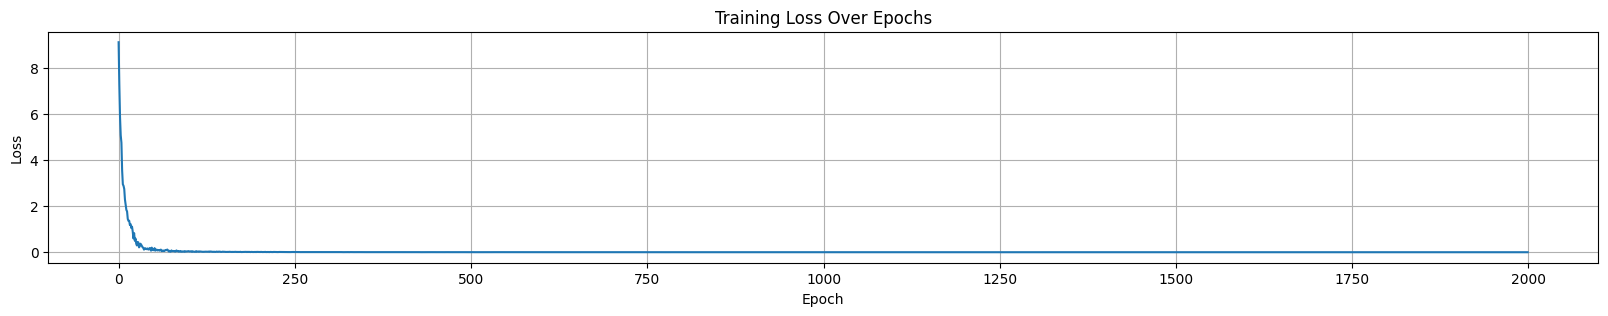

In [17]:
print("\nStep 3.1: Starting Multi-Modal Training Loop...")

# List to track losses
losses = []

# --- Set Layers to Training Mode ---
# Theory: Ensure layers like LayerNorm are in training mode. Vision model remains in eval.
token_embedding_table.train()
vision_projection_layer.train()
for i in range(n_layers):
    layer_norms_1[i].train()
    mha_qkv_linears[i].train()
    mha_output_linears[i].train() # Use correct name
    layer_norms_2[i].train()
    ffn_linear_1[i].train()
    ffn_linear_2[i].train()
final_layer_norm.train()
output_linear_layer.train()
# vision_model remains in eval() mode

# --- Training Loop ---
for epoch in range(epochs):

    # --- 1. Batch Selection ---
    indices = torch.randint(0, num_sequences_available, (batch_size,))
    # Retrieve data for the batch
    xb_ids = all_input_ids[indices].to(device)          # (B, T)
    yb_ids = all_target_ids[indices].to(device)          # (B, T)
    batch_masks = all_attention_masks[indices].to(device) # (B, T) - Basic padding mask
    batch_img_paths = [all_image_paths[i] for i in indices.tolist()]
    # Retrieve pre-extracted features and stack them into a batch
    try:
        batch_img_features = torch.stack([extracted_image_features[p] for p in batch_img_paths]).to(device) # (B, vision_feature_dim)
    except KeyError as e:
        print(f"Error: Missing extracted feature for image path {e}. Ensure Step 1.1 completed correctly. Skipping epoch.")
        continue


    # --- 2. Forward Pass (Inline) ---
    B, T = xb_ids.shape # T is block_size
    C = d_model

    # --- Project Image Features ---
    # Theory: Map image features to the Transformer's dimension (d_model).
    projected_img_features = vision_projection_layer(batch_img_features) # (B, C)
    # Unsqueeze to add the sequence dimension for concatenation/addition: (B, 1, C)
    projected_img_features = projected_img_features.unsqueeze(1)
    # Replicate if num_img_tokens > 1 (not needed here as num_img_tokens is 1)
    # if num_img_tokens > 1:
    #     projected_img_features = projected_img_features.repeat(1, num_img_tokens, 1) # (B, num_img_tokens, C)


    # --- Get Text Embeddings ---
    # Theory: Get embeddings for the entire input ID sequence (including <IMG> placeholders).
    text_token_embeddings = token_embedding_table(xb_ids) # (B, T, C)

    # --- Combine Modalities ---
    # Theory: Replace the embedding of the <IMG> token(s) with the projected image features.
    # Since num_img_tokens is 1, we replace the embedding at index 0.
    combined_embeddings = text_token_embeddings.clone() # Avoid modifying original tensor inplace
    combined_embeddings[:, 0:num_img_tokens, :] = projected_img_features # Simple replacement/injection

    # --- Add Positional Encoding ---
    # Theory: Add positional information to the combined sequence. Slice PE to match T.
    pos_enc_slice = positional_encoding[:, :T, :] # (1, T, C)
    x = combined_embeddings + pos_enc_slice # (B, T, C)

    # --- Transformer Blocks ---
    # This part is identical to the text-only model's forward pass,
    # but now 'x' contains fused image+text info.
    # We also need to incorporate the padding mask into the attention mechanism.
    # Create the combined attention mask: causal + padding
    # Expand padding mask for multi-head: (B, T) -> (B, 1, 1, T)
    padding_mask_expanded = batch_masks.unsqueeze(1).unsqueeze(2) # (B, 1, 1, T)
    # Combined mask: causal AND padding. Result is 0 where attention is NOT allowed.
    # Causal mask is (1, 1, T, T). Padding mask is (B, 1, 1, T). Broadcasting applies.
    combined_attn_mask = causal_mask[:,:,:T,:T] * padding_mask_expanded # (B, 1, T, T)


    for i in range(n_layers):
        x_input_block = x
        # Pre-LN MHA
        x_ln1 = layer_norms_1[i](x_input_block)
        qkv = mha_qkv_linears[i](x_ln1)
        qkv = qkv.view(B, T, n_heads, 3 * d_k).permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        attn_scores = (q @ k.transpose(-2, -1)) * (d_k ** -0.5) # (B, n_heads, T, T)

        # Apply Combined Mask (Causal + Padding)
        # We need to expand the mask to match the number of heads, or let broadcasting handle it.
        # Pytorch masked_fill needs mask shape broadcastable to scores shape.
        # combined_attn_mask shape is (B, 1, T, T), attn_scores is (B, n_heads, T, T). Broadcasting works.
        attn_scores_masked = attn_scores.masked_fill(combined_attn_mask == 0, float('-inf'))

        attention_weights = F.softmax(attn_scores_masked, dim=-1) # (B, n_heads, T, T)
        # Handle potential NaNs if a row in softmax is all -inf (e.g., all padding)
        attention_weights = torch.nan_to_num(attention_weights)

        attn_output = attention_weights @ v # (B, n_heads, T, d_k)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(B, T, C)
        mha_result = mha_output_linears[i](attn_output) # Use correct name
        x = x_input_block + mha_result # Residual 1

        # Pre-LN FFN
        x_input_ffn = x
        x_ln2 = layer_norms_2[i](x_input_ffn)
        ffn_hidden = ffn_linear_1[i](x_ln2)
        ffn_activated = F.relu(ffn_hidden)
        ffn_output = ffn_linear_2[i](ffn_activated)
        x = x_input_ffn + ffn_output # Residual 2

    # --- Final Layers ---
    final_norm_output = final_layer_norm(x) # (B, T, C)
    logits = output_linear_layer(final_norm_output) # (B, T, vocab_size)

    # --- 3. Calculate Loss ---
    # Theory: Calculate CrossEntropyLoss between predicted logits and target IDs.
    # The loss function automatically ignores targets with value ignore_index (-100).
    # Reshape logits and targets for the loss function.
    # In Step 3.1: Multi-Modal Training Loop

    B_loss, T_loss, V_loss = logits.shape
    # print(f"Shapes: logits={logits.shape}, targets={yb_ids.shape}")

    # Ensure targets match the sequence length dimension of logits
    if yb_ids.size(1) != T_loss:

        ##### Debugging: Check if the target sequence is longer than the logits sequence
        # print(f"Adjusting target sequence length from {yb_ids.size(1)} to {T_loss}")
        if yb_ids.size(1) > T_loss:
            # Truncate if targets are longer
            targets_reshaped = yb_ids[:, :T_loss].contiguous().view(-1)
        else:
            # Pad with ignore_index if targets are shorter (shouldn't happen with the fix above)
            padded_targets = torch.full((B_loss, T_loss), ignore_index, device=device)
            padded_targets[:, :yb_ids.size(1)] = yb_ids
            targets_reshaped = padded_targets.view(-1)
    else:
        # Shapes match correctly
        targets_reshaped = yb_ids.view(-1)

    logits_reshaped = logits.view(-1, V_loss)
    loss = criterion(logits_reshaped, targets_reshaped)

    # --- 4. Zero Gradients ---
    optimizer.zero_grad()

    # --- 5. Backward Pass ---
    # Check if loss is valid before backprop
    if not torch.isnan(loss) and not torch.isinf(loss):
        loss.backward()
         # --- Optional: Gradient Clipping ---
        # Theory: Prevents exploding gradients, common in Transformers.
        # torch.nn.utils.clip_grad_norm_(all_trainable_parameters, max_norm=1.0)

        # --- 6. Update Parameters ---
        optimizer.step()
    else:
        print(f"Warning: Invalid loss detected (NaN or Inf) at epoch {epoch+1}. Skipping optimizer step.")
        loss = None # Set loss to None if invalid

    # --- Logging ---
    if loss is not None:
        current_loss = loss.item()
        losses.append(current_loss)
        if epoch % eval_interval == 0 or epoch == epochs - 1:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {current_loss:.4f}")
    elif epoch % eval_interval == 0 or epoch == epochs - 1:
         print(f"  Epoch {epoch+1}/{epochs}, Loss: Invalid (NaN/Inf)")


print("--- Multi-Modal Training Loop Completed ---\
")

# Optional: Plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Step 4: Multi-Modal Generation (Inline)

**Goal:** Use the fine-tuned model to generate a response given a new image and a text prompt.

#### Step 4.1: Prepare Input Image and Prompt

**Theory:** Select an image (e.g., one from the sample set or a new one) and a text prompt. Preprocess the image, extract its features using the `vision_model`, and project them using the trained `vision_projection_layer`. Tokenize the prompt and prepend the `<IMG>` token ID. This forms the initial context for generation.

In [18]:
print("Step 4.1: Preparing input image and prompt for generation...")

# --- Choose Image and Prompt ---
# Let's try generating a description for the green circle
test_image_path = image_paths["green"]
test_prompt_text = "Describe this image: "

# --- Process Image ---
try:
    test_img = Image.open(test_image_path).convert('RGB')
    test_img_tensor = image_transforms(test_img).unsqueeze(0).to(device)
    with torch.no_grad(): # No gradients needed for feature extraction
        test_img_features_raw = vision_model(test_img_tensor) # (1, vision_feature_dim)
    # Project features using the TRAINED projection layer
    vision_projection_layer.eval() # Ensure projection layer is in eval mode
    with torch.no_grad():
        test_img_features_projected = vision_projection_layer(test_img_features_raw) # (1, d_model)
    print(f"  Processed image: '{os.path.basename(test_image_path)}'")
    print(f"  Projected image features shape: {test_img_features_projected.shape}")
except FileNotFoundError:
    print(f"Error: Test image not found at {test_image_path}. Cannot generate.")
    # Handle error appropriately, maybe exit or skip generation
    test_img_features_projected = None # Indicate error

# --- Process Prompt ---
if test_img_features_projected is not None:
    img_id = char_to_int[img_token]
    prompt_ids = [char_to_int[ch] for ch in test_prompt_text]
    # Initial sequence IDs: [<IMG>, prompt tokens]
    initial_context_ids = torch.tensor([[img_id] * num_img_tokens + prompt_ids], dtype=torch.long, device=device) # Shape: (1, 1 + len(prompt))
    print(f"  Tokenized prompt: '{test_prompt_text}' -> {initial_context_ids.tolist()}")
else:
     initial_context_ids = None

# --- Generation Parameters ---
max_new_tokens = 50 # Max characters to generate for the response
eos_token_id = char_to_int[eos_token]
print(f"  Set max new tokens to generate: {max_new_tokens}")

Step 4.1: Preparing input image and prompt for generation...
  Processed image: 'green_circle.png'
  Projected image features shape: torch.Size([1, 64])
  Tokenized prompt: 'Describe this image: ' -> [[36, 41, 18, 30, 16, 29, 22, 15, 18, 1, 31, 21, 22, 30, 1, 22, 25, 14, 20, 18, 8, 1]]
  Set max new tokens to generate: 50


#### Step 4.2: The Generation Loop (Autoregressive Decoding)

**Theory:** Generate the response character by character.
1.  Start with the initial context (image + prompt).
2.  In a loop (`torch.no_grad`):
    a.  Prepare the current input sequence (making sure it doesn't exceed `block_size`). Get embeddings for token IDs. Replace `<IMG>` embedding with the pre-calculated projected image features. Add positional encoding. Create attention mask (no padding needed initially, only causal).
    b.  Pass the prepared input through the Transformer blocks (ensure layers are in `eval` mode).
    c.  Get the logits for the *very last* token position in the sequence.
    d.  Apply Softmax to get probabilities.
    e.  Sample the next token ID based on the probabilities (e.g., using `torch.multinomial` or taking the `argmax` for greedy decoding).
    f.  Append the sampled token ID to the current sequence.
    g.  If the sampled token is `<EOS>` or `max_new_tokens` are generated, stop.
    h.  Repeat.

In [19]:
print("\nStep 4.2: Starting generation loop...")

# --- Set Model to Evaluation Mode ---
token_embedding_table.eval()
# vision_projection_layer is already eval
for i in range(n_layers):
    layer_norms_1[i].eval()
    mha_qkv_linears[i].eval()
    mha_output_linears[i].eval()
    layer_norms_2[i].eval()
    ffn_linear_1[i].eval()
    ffn_linear_2[i].eval()
final_layer_norm.eval()
output_linear_layer.eval()

# --- Generation ---
generated_sequence_ids = initial_context_ids # Start with image + prompt
if generated_sequence_ids is not None:
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # --- Prepare Input ---
            current_ids_context = generated_sequence_ids[:, -block_size:] # Ensure context fits block_size
            B_gen, T_gen = current_ids_context.shape
            C_gen = d_model

            # Get embeddings for current context IDs
            current_token_embeddings = token_embedding_table(current_ids_context) # (B_gen, T_gen, C_gen)

            # Inject image features (only needed if <IMG> is within the current context window)
            # Find the position of the <IMG> token(s) in the current context
            img_token_pos = -1
            if img_id in current_ids_context[0].tolist():
                 # Simple check assuming only one <IMG> at the start of the original sequence
                 if current_ids_context[0, 0] == img_id:
                      img_token_pos = 0

            gen_combined_embeddings = current_token_embeddings
            if img_token_pos != -1: # Check if the image token is present in the window
                 # Inject pre-calculated projected features for the image token(s)
                 # Assume only one image token at pos 0 for simplicity
                 gen_combined_embeddings[:, img_token_pos:(img_token_pos + num_img_tokens), :] = test_img_features_projected # (1, C) broadcasted/sliced


            # Add Positional Encoding (sliced for current context length T_gen)
            pos_enc_slice_gen = positional_encoding[:, :T_gen, :]
            x_gen = gen_combined_embeddings + pos_enc_slice_gen

            # --- Transformer Blocks ---
            # Create causal mask for current length T_gen
            gen_causal_mask = causal_mask[:,:,:T_gen,:T_gen] # (1, 1, T_gen, T_gen)
            # No padding mask needed here as we generate one token at a time / handle context length

            for i in range(n_layers):
                x_input_block_gen = x_gen
                # Pre-LN MHA
                x_ln1_gen = layer_norms_1[i](x_input_block_gen)
                qkv_gen = mha_qkv_linears[i](x_ln1_gen)
                qkv_gen = qkv_gen.view(B_gen, T_gen, n_heads, 3 * d_k).permute(0, 2, 1, 3)
                q_gen, k_gen, v_gen = qkv_gen.chunk(3, dim=-1)
                attn_scores_gen = (q_gen @ k_gen.transpose(-2, -1)) * (d_k ** -0.5)
                attn_scores_masked_gen = attn_scores_gen.masked_fill(gen_causal_mask == 0, float('-inf'))
                attention_weights_gen = F.softmax(attn_scores_masked_gen, dim=-1)
                attention_weights_gen = torch.nan_to_num(attention_weights_gen)
                attn_output_gen = attention_weights_gen @ v_gen
                attn_output_gen = attn_output_gen.permute(0, 2, 1, 3).contiguous().view(B_gen, T_gen, C_gen)
                mha_result_gen = mha_output_linears[i](attn_output_gen)
                x_gen = x_input_block_gen + mha_result_gen # Residual 1
                # Pre-LN FFN
                x_input_ffn_gen = x_gen
                x_ln2_gen = layer_norms_2[i](x_input_ffn_gen)
                ffn_hidden_gen = ffn_linear_1[i](x_ln2_gen)
                ffn_activated_gen = F.relu(ffn_hidden_gen)
                ffn_output_gen = ffn_linear_2[i](ffn_activated_gen)
                x_gen = x_input_ffn_gen + ffn_output_gen # Residual 2

            # --- Final Layers ---
            final_norm_output_gen = final_layer_norm(x_gen)
            logits_gen = output_linear_layer(final_norm_output_gen) # (B_gen, T_gen, vocab_size)

            # --- Get Logits for Last Token ---
            logits_last_token = logits_gen[:, -1, :] # (B_gen, vocab_size)

            # --- Sample Next Token ---
            probs = F.softmax(logits_last_token, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1) # (B_gen, 1)

            # --- Append and Check for EOS ---
            generated_sequence_ids = torch.cat((generated_sequence_ids, next_token_id), dim=1)

            if next_token_id.item() == eos_token_id:
                print("  <EOS> token generated. Stopping.")
                break
        else: # Loop finished without hitting EOS
             print(f"  Reached max generation length ({max_new_tokens}). Stopping.")

else:
    print("Generation skipped due to error in preparing input.")

print("--- Generation Loop Finished ---")


Step 4.2: Starting generation loop...
  Reached max generation length (50). Stopping.
--- Generation Loop Finished ---


#### Step 4.3: Decode Generated Sequence

**Theory:** Convert the final sequence of token IDs (including the initial prompt and the newly generated tokens) back into a human-readable string using the `int_to_char` mapping.

In [20]:
print("\nStep 4.3: Decoding generated sequence...")

if generated_sequence_ids is not None:
    # Extract the generated IDs (excluding the initial <IMG> token if desired)
    final_ids_list = generated_sequence_ids[0].tolist()

    # Decode the full sequence
    decoded_text = ""
    for id_val in final_ids_list:
        # Avoid trying to decode potential ignore_index if it slipped through
        if id_val in int_to_char:
            decoded_text += int_to_char[id_val]
        else:
            decoded_text += f"[UNK:{id_val}]" # Handle unknown IDs


    print(f"\n--- Final Generated Output ---")
    print(f"Image: {os.path.basename(test_image_path)}")
    # Displaying the prompt and response part
    # Find start of response (first token after prompt)
    response_start_index = num_img_tokens + len(test_prompt_text)
    print(f"Prompt: {test_prompt_text}")
    print(f"Generated Response: {decoded_text[response_start_index:]}")
    # print(f"Full Decoded Sequence: {decoded_text}") # Optional: print everything
else:
    print("Decoding skipped.")


Step 4.3: Decoding generated sequence...

--- Final Generated Output ---
Image: green_circle.png
Prompt: Describe this image: 
Generated Response: ge:   of    siiiiiiiiiiittttttttttteeeeeeeeeeeeeeeeeee


### Step 6: Save the model state (optional)

To save our pretrained multi-modal model, you need to create a dictionary with all model components and configurations, then use torch.save(). Here's how to do it:

In [21]:
import os

# Create the directory if it doesn't exist
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'multimodal_model.pt')

# Create a dictionary with all model components and configurations
multimodal_state_dict = {
    # Configuration
    'config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'd_ff': d_ff,
        'block_size': block_size,
        'num_img_tokens': num_img_tokens,
        'vision_feature_dim': vision_feature_dim
    },
    # Tokenizer
    'tokenizer': {
        'char_to_int': char_to_int,
        'int_to_char': int_to_char
    },
    # Model weights
    'token_embedding_table': token_embedding_table.state_dict(),
    'vision_projection_layer': vision_projection_layer.state_dict(),
    'positional_encoding': positional_encoding,
    'layer_norms_1': [ln.state_dict() for ln in layer_norms_1],
    'mha_qkv_linears': [l.state_dict() for l in mha_qkv_linears],
    'mha_output_linears': [l.state_dict() for l in mha_output_linears],
    'layer_norms_2': [ln.state_dict() for ln in layer_norms_2],
    'ffn_linear_1': [l.state_dict() for l in ffn_linear_1],
    'ffn_linear_2': [l.state_dict() for l in ffn_linear_2],
    'final_layer_norm': final_layer_norm.state_dict(),
    'output_linear_layer': output_linear_layer.state_dict()
}

# Save to file
torch.save(multimodal_state_dict, save_path)
print(f"Multi-modal model saved to {save_path}")

Multi-modal model saved to saved_models\multimodal_model.pt


Here's how to load our saved multi-modal model:

In [22]:
# Load the saved model state dictionary
model_load_path = 'saved_models/multimodal_model.pt'
loaded_state_dict = torch.load(model_load_path, map_location=device)
print(f"Loaded state dictionary from '{model_load_path}'.")

# Extract configuration and tokenizer
config = loaded_state_dict['config']
vocab_size = config['vocab_size']
d_model = config['d_model']
n_heads = config['n_heads']
n_layers = config['n_layers']
d_ff = config['d_ff']
block_size = config['block_size']
num_img_tokens = config['num_img_tokens']
vision_feature_dim = config['vision_feature_dim']
d_k = d_model // n_heads

char_to_int = loaded_state_dict['tokenizer']['char_to_int']
int_to_char = loaded_state_dict['tokenizer']['int_to_char']

# Recreate causal mask
causal_mask = torch.tril(torch.ones(block_size, block_size, device=device)).view(1, 1, block_size, block_size)

# Rebuild model components
token_embedding_table = nn.Embedding(vocab_size, d_model).to(device)
token_embedding_table.load_state_dict(loaded_state_dict['token_embedding_table'])

vision_projection_layer = nn.Linear(vision_feature_dim, d_model).to(device)
vision_projection_layer.load_state_dict(loaded_state_dict['vision_projection_layer'])

positional_encoding = loaded_state_dict['positional_encoding'].to(device)

# Initialize transformer layers
layer_norms_1 = []
mha_qkv_linears = []
mha_output_linears = []
layer_norms_2 = []
ffn_linear_1 = []
ffn_linear_2 = []

for i in range(n_layers):
    # For each layer, create components and load their state dictionaries
    ln1 = nn.LayerNorm(d_model).to(device)
    ln1.load_state_dict(loaded_state_dict['layer_norms_1'][i])
    layer_norms_1.append(ln1)
    
    # For the QKV linear layer, we need to match the bias parameter
    qkv_dict = loaded_state_dict['mha_qkv_linears'][i]
    has_qkv_bias = 'bias' in qkv_dict
    qkv = nn.Linear(d_model, 3 * d_model, bias=has_qkv_bias).to(device)
    qkv.load_state_dict(qkv_dict)
    mha_qkv_linears.append(qkv)
    
    # Similar approach for other linear layers
    out_dict = loaded_state_dict['mha_output_linears'][i]
    has_out_bias = 'bias' in out_dict
    out = nn.Linear(d_model, d_model, bias=has_out_bias).to(device)
    out.load_state_dict(out_dict)
    mha_output_linears.append(out)
    
    ln2 = nn.LayerNorm(d_model).to(device)
    ln2.load_state_dict(loaded_state_dict['layer_norms_2'][i])
    layer_norms_2.append(ln2)
    
    ff1_dict = loaded_state_dict['ffn_linear_1'][i]
    has_ff1_bias = 'bias' in ff1_dict
    ff1 = nn.Linear(d_model, d_ff, bias=has_ff1_bias).to(device)
    ff1.load_state_dict(ff1_dict)
    ffn_linear_1.append(ff1)
    
    ff2_dict = loaded_state_dict['ffn_linear_2'][i]
    has_ff2_bias = 'bias' in ff2_dict
    ff2 = nn.Linear(d_ff, d_model, bias=has_ff2_bias).to(device)
    ff2.load_state_dict(ff2_dict)
    ffn_linear_2.append(ff2)

# Final layer norm and output projection
final_layer_norm = nn.LayerNorm(d_model).to(device)
final_layer_norm.load_state_dict(loaded_state_dict['final_layer_norm'])

output_dict = loaded_state_dict['output_linear_layer']
has_output_bias = 'bias' in output_dict
output_linear_layer = nn.Linear(d_model, vocab_size, bias=has_output_bias).to(device)
output_linear_layer.load_state_dict(output_dict)

print("Multi-modal model components loaded successfully.")

Loaded state dictionary from 'saved_models/multimodal_model.pt'.
Multi-modal model components loaded successfully.


After loading the model, you can use it for inference with the same forward pass logic you used during training. To generate text based on an image and a prompt:

In [23]:
def generate_with_image(image_path, prompt, max_new_tokens=50):
    """Generate text response for an image and prompt"""
    # Set everything to evaluation mode
    token_embedding_table.eval()
    vision_projection_layer.eval()
    for i in range(n_layers):
        layer_norms_1[i].eval()
        mha_qkv_linears[i].eval()
        mha_output_linears[i].eval()
        layer_norms_2[i].eval()
        ffn_linear_1[i].eval()
        ffn_linear_2[i].eval()
    final_layer_norm.eval()
    output_linear_layer.eval()
    
    # Process image
    image = Image.open(image_path).convert('RGB')
    img_tensor = image_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Extract and project image features
        img_features_raw = vision_model(img_tensor)
        img_features_projected = vision_projection_layer(img_features_raw)
        
        # Tokenize prompt and prepare initial sequence
        img_id = char_to_int[img_token]
        prompt_ids = [char_to_int[ch] for ch in prompt]
        context_ids = torch.tensor([[img_id] + prompt_ids], dtype=torch.long, device=device)
        
        # Generation loop
        for _ in range(max_new_tokens):
            # Use only the last block_size tokens if context gets too long
            context_ids = context_ids[:, -block_size:]
            
            # Generation step (using the same forward logic as in training)
            # [Generation logic goes here - follow the same steps as in Step 4.2]
            
            # Get the next token prediction
            # [Logic to get next token]
            
            # Check for EOS token
            # [Logic to check for EOS and break]
            
        # Format and return results
        # [Logic to decode and return the result]

### Step 6: Conclusion

This notebook demonstrated an end-to-end, inline implementation of extending a pre-trained text-only Transformer into a basic multi-modal model capable of processing image features alongside text prompts.

Key steps included:
1.  **Loading:** Reusing the previously trained text Transformer's weights and configuration.
2.  **Vocabulary Extension:** Adding special tokens (`<IMG>`, `<PAD>`, `<EOS>`) required for the multi-modal setup.
3.  **Vision Integration:** Using a pre-trained ResNet-18 to extract image features and adding a learnable projection layer to map these features into the Transformer's embedding space.
4.  **Data Preparation:** Creating sample (Image, Prompt, Response) data, extracting features, tokenizing text, and constructing padded input sequences with appropriate target IDs (using `ignore_index`) and attention masks.
5.  **Model Adaptation:** Resizing embedding/output layers for the new vocabulary and initializing the vision projection layer.
6.  **Training:** Fine-tuning the model (text components + vision projection) on the multi-modal data using a combined input sequence (image features injected into `<IMG>` token embeddings + text embeddings) and masked cross-entropy loss.
7.  **Generation:** Performing autoregressive decoding by providing an image (features) and a prompt, then iteratively predicting the next character token until an `<EOS>` token or maximum length is reached.

While this inline approach is verbose and uses simplifications (like basic feature injection, small data, no vision model fine-tuning), it meticulously illustrates the fundamental concepts and steps involved in building a multi-modal Transformer system. Real-world applications would leverage more sophisticated fusion techniques (e.g., cross-attention), larger datasets, and standard programming practices (functions, classes) for better code organization and scalability.